# Version 2023/11/17(now using)

# import

In [89]:
import math
import os
import sys
import random
import pandas as pd
import openpyxl 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('fivethirtyeight')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 15
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import itertools
import warnings
warnings.filterwarnings("ignore")

# Data Import And Preprocessing(Cleaning)

In [90]:
# print (os.path.abspath('./'))
file_path='loans_head.csv'
#定义空值 便于数据清洗
missing_values=['0','0.0','0.00','n/a','na']
data1 = pd.read_csv(file_path,na_values=missing_values)
# print('\n')
print(data1.info())
print(data1.head(5))
# data1.iloc[:,1056]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Columns: 1057 entries, observation_date to 1055
dtypes: float64(1056), object(1)
memory usage: 396.5+ KB
None
  observation_date        0         1        2         3        4         5   
0       2018-07-01   982.97  58505.02  3070.36   4592.62  2224.89       NaN  \
1       2018-08-01  1666.17  58505.02  2820.75   5914.47      NaN       NaN   
2       2018-09-01  1687.53  58505.02  2820.75  16080.82      NaN       NaN   
3       2018-10-01  1687.53  60017.18  2840.62  57914.94      NaN  57914.94   
4       2018-11-01   678.20  84276.35  2840.62  57914.94      NaN  57914.94   

          6         7          8  ...  1046  1047  1048  1049  1050  1051   
0   8540.45  18950.23  202457.22  ...   NaN   NaN   NaN   NaN   NaN   NaN  \
1  23890.52  18950.23  202457.22  ...   NaN   NaN   NaN   NaN   NaN   NaN   
2  10901.71   5443.82  202457.22  ...   NaN   NaN   NaN   NaN   NaN   NaN   
3  10901.71   9407.93  219351.46  ...

In [91]:
# 仅保留存在四十八（可更改）个以上非空值的列
df=data1.dropna(axis=1,thresh=48)
#str类型转为date类型
df.loc[:,"observation_date"] = [datetime.strptime(i,'%Y-%m-%d') for i in df.loc[:,"observation_date"]]
# format date 类型 为%Y-%m
df.loc[:,"observation_date"] = [datetime.strftime(i,'%Y-%m') for i in df.loc[:,"observation_date"]]  
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Columns: 650 entries, observation_date to 1000
dtypes: float64(649), object(1)
memory usage: 243.9+ KB


,observation_date,0,1,2,3,7,8,10,11,12,...,988,989,990,991,992,993,995,996,997,1000
0,2018-07,982.97,58505.02,3070.36,4592.62,18950.23,202457.22,13526.97,123618.61,13225.88,...,1529.53,33340.51,2176.88,2333.36,6952.88,15883.88,3006.96,2172.49,7502.69,96269.05
1,2018-08,1666.17,58505.02,2820.75,5914.47,18950.23,202457.22,13526.97,123618.61,33027.98,...,822.45,33340.51,18553.84,2333.36,6952.88,15883.88,3006.96,6110.00,3270.93,96269.05
2,2018-09,1687.53,58505.02,2820.75,16080.82,5443.82,202457.22,4667.62,58764.84,33027.98,...,472.36,12911.97,18553.84,2333.36,27565.32,15883.88,3006.96,6110.00,3270.93,111323.25
3,2018-10,1687.53,60017.18,2840.62,57914.94,9407.93,219351.46,4667.62,58764.84,39294.41,...,591.76,12830.39,18553.84,2779.75,27565.32,15883.88,3006.96,6110.00,3270.93,122514.56
4,2018-11,678.20,84276.35,2840.62,57914.94,9407.93,219351.46,4667.62,58764.84,39294.41,...,475.32,33953.16,18553.84,2779.75,27565.32,68110.19,4306.54,6110.00,3270.93,36396.73


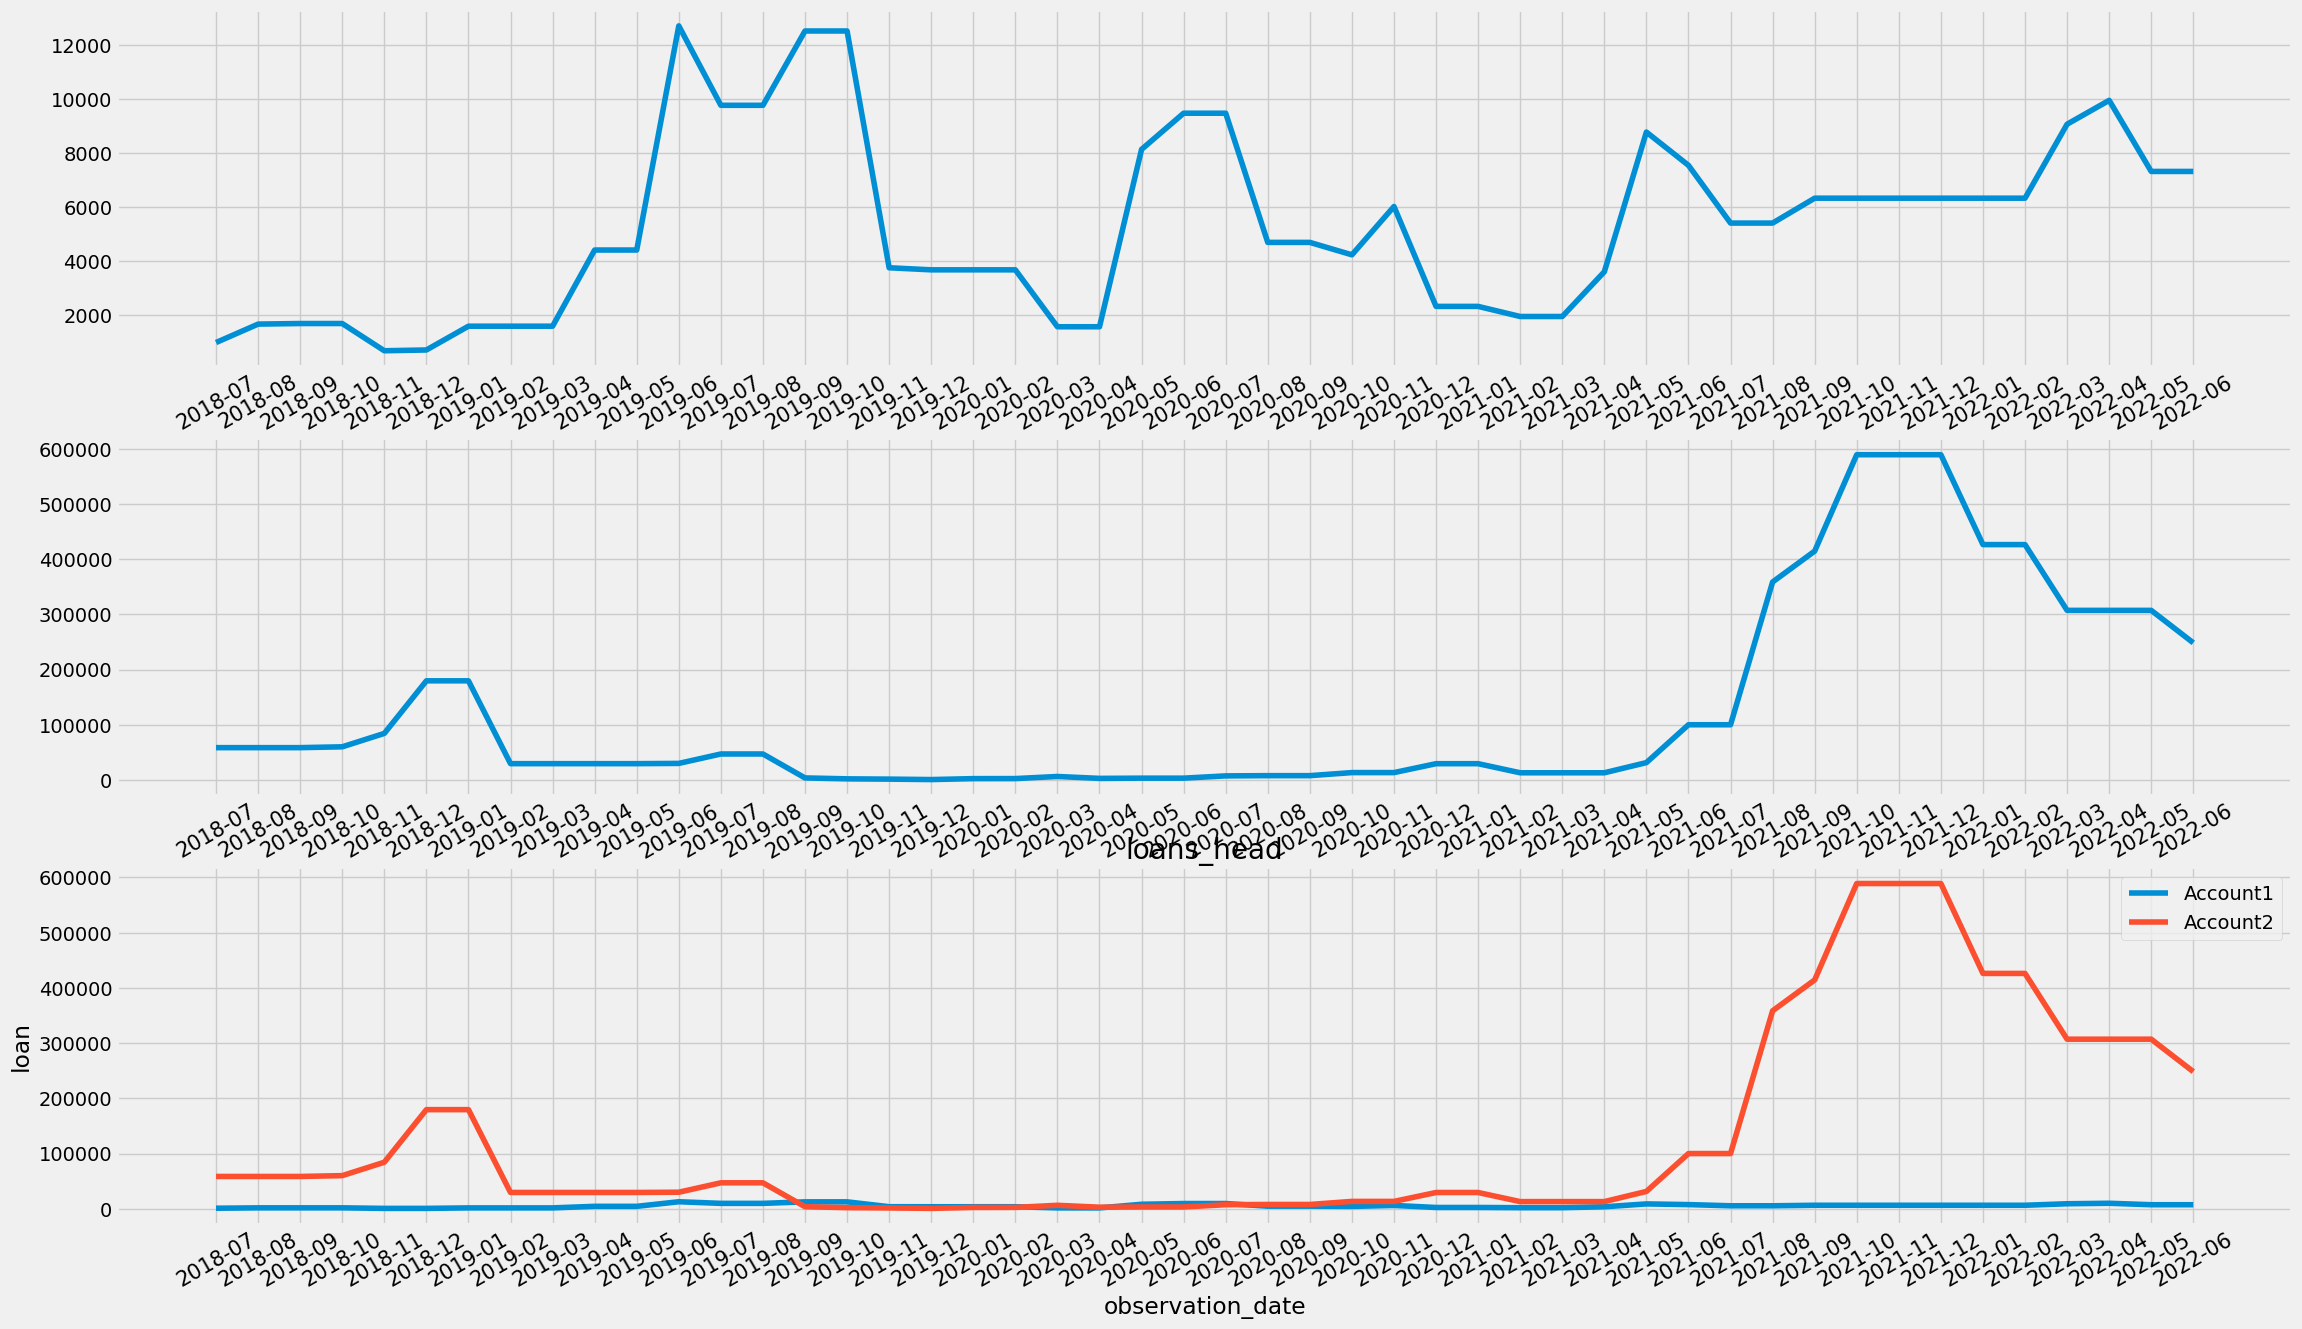

In [92]:
x=df.observation_date
# 分别绘制第一列和第二列随日期的变化以及两列在同一坐标系下的情况
# 数据数量级差异过大，且账户数量过多，是否应该考虑将所有数据求和或取平均等办法处理？
Account1=df.iloc[:,1]
Account2=df.iloc[:,2]
fig,ax=plt.subplots(3,1)
for i in range(0,3):
    ax[i].tick_params(axis='x', labelsize=15)
    ax[i].tick_params(axis='x', labelrotation= 30) 
ax[0].plot(x,Account1,label='Account1')
ax[1].plot(x,Account2,label='Account2')
ax[2].plot(x,Account1,label='Account1')
ax[2].plot(x,Account2,label='Account2')
ax[2].set_xlabel('observation_date')
ax[2].set_ylabel('loan')
ax[2].set_title('loans_head')
ax[2].legend()

# SARIMA

## test_stationarity

序列平稳性检验方法选择：（单位根检验）

1.可视化数据（作图主观判断）

2.简单统计方法（将数据分为两段，对比两段数据的均值方差，判断是否存在明显差异）

3.假设检验方法：3.1 DF检验 3.2 ADF检验 3.3 PP检验 3.4 DF-GLS检验 3.5 KPSS检验 （建议询问CHAT-GPT选用哪种假设检验方式）（一天）

4.若检验发现数据不平稳，通过差分使数据平稳，使用的差分阶数即为需要的参数d（两天）

# GET DEGREE P and Q
绘制原序列图（半天）
ACF图（半天）
PACF图（半天）
以判断历史数据走势及p、q阶数
亦可采用网格搜索法自动确定阶数（p,q,P,Q）（两天）

# MODEL AND PREDICT
获取参数后可根据公式拟合曲线判断未来走势（一天？）
绘图

# TEST MODEL
残差 相关性（一天？）


# Model OPTIMIZATION
考虑是否必要？

参考：

https://zhuanlan.zhihu.com/p/425664064

https://zhuanlan.zhihu.com/p/531987920

